In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') 

import warnings
warnings.filterwarnings('once')

In [2]:
# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [3]:
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

# Data

Formaremos un modelo de prediccion para las ventas mensuales.

In [4]:
path = r'Ventas por mes.csv'
sales = pd.read_csv(path)

sales = sales.rename(columns={'YearMonthnumber':'date','Fact Real':'Sales'})
sales['date'] = pd.to_datetime(sales['date'],format='%Y-%m-%d')
sales = sales.set_index('date')
sales = sales.asfreq('MS')

sales = sales['Sales']

sales.head(4)

date
2014-01-01    133659.6003
2014-02-01     45445.5470
2014-03-01    183719.5746
2014-04-01     81818.2348
Freq: MS, Name: Sales, dtype: float64

Usaremos el 70% de nuestros datos como entrenamiento.

In [ ]:
time_train = '2016-10-01 00:00:00'
print(
    f"Fechas train : {sales.index.min()} - {sales.loc[:time_train].index.max()}  "
    f"(n={len(sales.loc[:time_train])})"
)
print(
    f"Fechas test  : {sales.loc[time_train:].index.min()} - {sales.loc[:].index.max()}  "
    f"(n={len(sales.loc[time_train:])})"
)
sales_train = sales.loc[:time_train]
sales_test  = sales.loc[time_train:]

Fechas train : 2014-01-01 00:00:00 --- 2016-10-01 00:00:00  (n=34)
Fechas test  : 2016-10-01 00:00:00 --- 2017-12-01 00:00:00  (n=15)


# Analisis Exploratorio de las ventas mensuales

In [ ]:
# Diferenciamos una vez
sales_diff_1 = sales_train.diff().dropna()

In [12]:
def test_esta(serie):
    warnings.filterwarnings("ignore")
    adfuller_result = adfuller(serie)
    kpss_result = kpss(serie)
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
    warnings.filterwarnings("default")

In [ ]:
print('Test estacionariedad serie original')
test_esta(sales)
print('\n ======================================================================================')
print('\nTest estacionariedad para serie diferenciada (orden=1)')
test_esta(sales_diff_1)

Test estacionariedad serie original
ADF Statistic: -4.604373698511155, p-value: 0.00012679308490072655
KPSS Statistic: 0.6281722650946001, p-value: 0.020075248627763623


Test estacionariedad para serie diferenciada (order=1)
ADF Statistic: -3.6405556588849706, p-value: 0.0050313818341363985
KPSS Statistic: 0.2958147736430439, p-value: 0.1


Para ``orden = 1``, pasamos los niveles de significancia en ambas pruebas de estacionariedad.

Por lo tanto podemos decir que $d=1$.

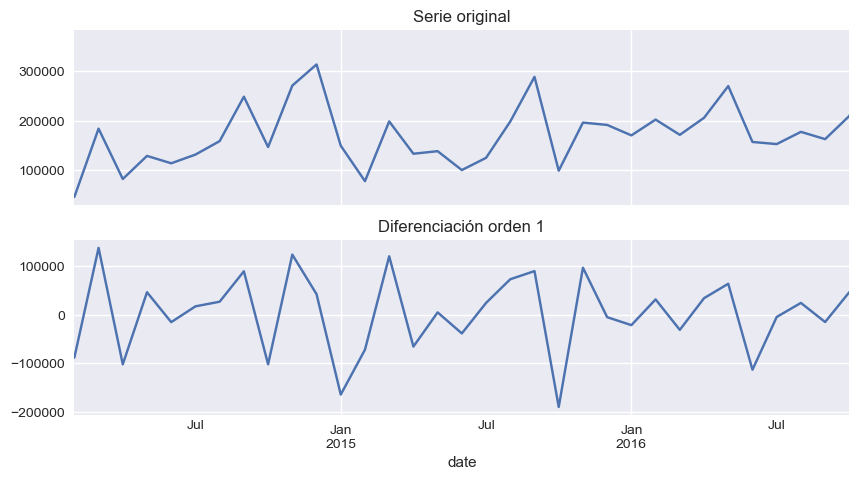

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
sales.plot(ax=axs[0],title='Serie original')
sales_diff_1.plot(ax=axs[1],title='Diferenciación orden 1')
plt.show()

## Descomposicion de la serie.

In [21]:
sales_stl = STL(sales).fit()
sales_add = seasonal_decompose(sales,model='multiplicative')
sales_mult = seasonal_decompose(sales,model='additive')

print(f'Promedio residuales descomposición aditiva: {sales_add.resid.mean()}')
print(f'\nPromedio residuales descomposición multiplicativa: {sales_mult.resid.mean()}')
print(f'\nPromedio residuales descomposición STL: {sales_stl.resid.mean()}')

Promedio residuales descomposición aditiva: 1.00414820023972

Promedio residuales descomposición multiplicativa: -622.770081134247

Promedio residuales descomposición STL: -51.83123256100286


El promedio de los residuos para la descomposicion aditiva es cercana a 0, este primer acercamiento es util para establecer el modelo de descomposicion a aplicar en nuestra serie.

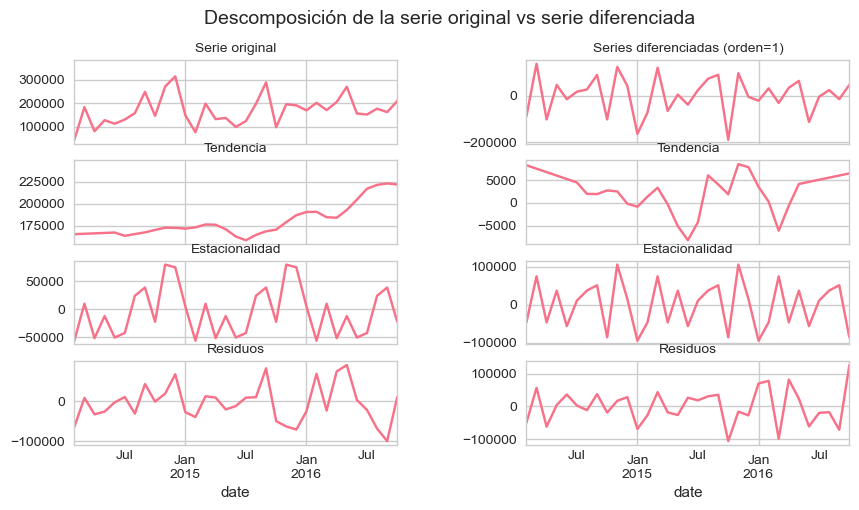

In [36]:
res_decompose = seasonal_decompose(sales, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(sales_diff_1, model='additive', extrapolate_trend='freq')

#Serie original
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 5), sharex=True, gridspec_kw={'wspace': 0.4})
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=10)

res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=10)

res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=10)

res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=10)

# Serie diferenciada
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (orden=1)', fontsize=10)

res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=10)

res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=10)

res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=10)

fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
plt.show()

Se puede notar que cada 12 meses se repite el patron de nuestra serie.

## Graficos de Autocorrelacion (q)

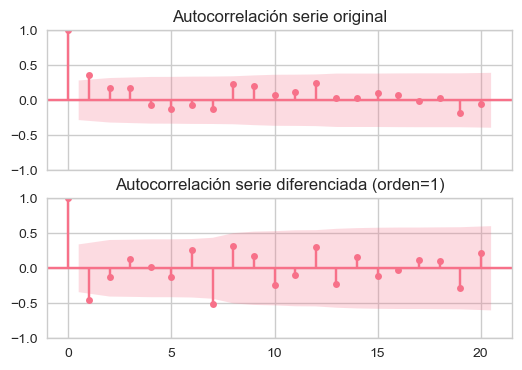

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(sales, ax=axs[0], lags=20, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(sales_diff_1, ax=axs[1], lags=20, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (orden=1)')
plt.show()

## Grafico Autocorrelacion Parcial (p)

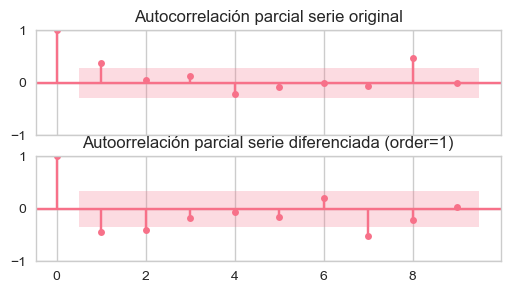

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(sales, ax=axs[0], lags=9, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(sales_diff_1, ax=axs[1], lags=9, alpha=0.05,method='ywm')
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.show()

En base a las graficas obtenidas ACF y PACF, podemos acotar los siguientes valores para $p$ y $q$:

$p \in [0,2]$

$q \in [0,1]$

# Primer Modelo

Podemos proponer un primer modelo con los siguientes hiperparametros: 


$p=1 \quad d=1, \quad q=1, \quad \text{estacionalidad}= 12$ 

$(1,1,1)[12]$


In [45]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

modelo = SARIMAX(endog = sales_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)

warnings.filterwarnings("default")
modelo_res.summary()

c:\Users\Ernes\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -264.596
Date:                            Fri, 17 Oct 2025   AIC                            539.192
Time:                                    17:47:18   BIC                            544.415
Sample:                                01-01-2014   HQIC                           540.326
                                     - 10-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3061      0.614      0.499      0.618      -0.897       1.509
ma.L1         -0.7394      0.613     -1.206      0.228      -1.941       0.462
ar.S.L12      -0.1012      1.140     -0.089      0.929      -2.335       2.132
ma.S.L12      -0.5526      1.202     -0.460      0.646      -2.908       1.803
sigma2      8.096e+09   2.39e-10   3.39e+19      0.000     8.1e+09     8.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.02   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.16   Prob(JB):                         0.58
Heteroskedasticity (H):               2.18   Skew:                             0.35
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+35. Standard errors may be unstable.
"""

In [46]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=250),
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(sales_train),
        refit              = True,
)
metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = sales,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                suppress_warnings_fit = True,
                              )

c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2 [00:00<?, ?it/s]

In [59]:
print(f"Metrica (mean absolute error) del modelo grid search:{metrica_m1.iat[0,0]:.2f}")

Metrica (mean absolute error) del modelo grid search:56573.36


Procederemos a entrenar el modelo para obtener los parametros optimos

# Busqueda de Hiperparametros

In [60]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), 
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12),(1, 1, 0,12),(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

In [61]:
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(sales_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = sales,
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
resultados_grid.head()

Number of models compared: 60.


c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


params grid:   0%|          | 0/60 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51079.187973,"(1, 1, 1)","(1, 1, 0, 12)",None
1,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51079.187973,"(1, 1, 1)","(1, 1, 0, 12)",n
2,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51939.651385,"(1, 1, 1)","(1, 1, 0, 12)",c
3,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",52768.555991,"(1, 1, 0)","(1, 1, 0, 12)",c
4,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",52858.469232,"(1, 1, 0)","(1, 1, 0, 12)",None


Los hiperparametros optimos son: (1, 1, 1)	(1, 1, 0, 12)

In [63]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), maxiter=250),
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(sales_train),
        refit              = True,
)
metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = sales,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                suppress_warnings_fit = True,
                              )

c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2 [00:00<?, ?it/s]

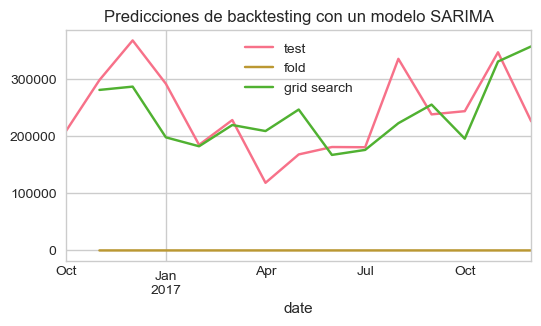

In [65]:
fig, ax = plt.subplots(figsize=(6, 3))
sales.loc[time_train:].plot(ax=ax, label='test')
predicciones_m2 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()
plt.show()

MEtricas

In [79]:
from sklearn import metrics
def metricas(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Resultado de evaluación de la Metrica:-')
    print(f'MSE es : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE es : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE es : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE es : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 es : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [80]:
metricas(sales_test[1:],predicciones_m2.iloc[:, 1])

Resultado de evaluación de la Metrica:-
MSE es : 4503335530.534136
MAE es : 51125.49755227244
RMSE es : 67106.89629638771
MAPE es : 22.993106512516835
R2 es : 0.13646428751345074



In [ ]:
df_metricas = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2'],
    'MAE': [metrica_m1, metrica_m2]
})

print(df_metricas)